Connect to server, create schema, and import required libraries

In [1]:
%matplotlib inline
import datajoint as dj
import json
import re
from os import path, mkdir

import numpy as np
import cv2
import imutils

from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
import requests
dj.config['enable_python_native_blobs'] = True

In [2]:
schema = dj.Schema('megan_travel')

Connecting megan@db.data-science-ust.net:3306


Create tables

In [3]:
@schema
class Travel(dj.Lookup):
    definition = """
    location : varchar(30)
    ---
    url : varchar(300)
    """
    
    contents = (
    ('Moscow', 'https://msds6311-final-meganwright612.s3.amazonaws.com/moscow.jpg'),
    ('Disney World', 'https://msds6311-final-meganwright612.s3.amazonaws.com/disney.jpg'),
    ('Tulum', 'https://msds6311-final-meganwright612.s3.amazonaws.com/tulum.jpg'),
    ('Iguazu Falls', 'https://msds6311-final-meganwright612.s3.amazonaws.com/iguazu.jpg'),
    ('Telc', 'https://msds6311-final-meganwright612.s3.amazonaws.com/telc.jpg')
    )

In [4]:
Travel()

*location      url           
+------------+ +------------+
Disney World   https://msds63
Iguazu Falls   https://msds63
Moscow         https://msds63
Telc           https://msds63
Tulum          https://msds63
 (Total: 5)

In [5]:
@schema
class TravelImage(dj.Imported):
    definition = """
    -> Travel
    ---
    location_image : longblob
    """
    def make(self,key):
        url = (Travel & key).fetch1('url')
        temp_file = url.split('/')[-1]
        with open(temp_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, location_image = plt.imread(temp_file)))

In [6]:
TravelImage.populate()

In [7]:
TravelImage()

*location      location_i
+------------+ +--------+
Disney World   =BLOB=    
Iguazu Falls   =BLOB=    
Moscow         =BLOB=    
Telc           =BLOB=    
Tulum          =BLOB=    
 (Total: 5)

View Original Images

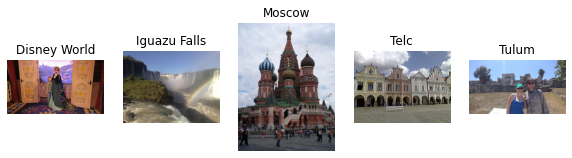

In [8]:
fig, axx = plt.subplots(1, 5, figsize=(10, 5))

for ax, info in zip(axx.flatten(), 
                    (TravelImage*Travel).fetch(as_dict=True)):
    ax.imshow(info['location_image'])
    ax.set_title(info['location'])
    ax.axis(False)

Import painting styles and apply to images

In [9]:
@schema
class PaintingStyle(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = (['udnie'], ['la_muse'], ['starry_night'], ['mosaic'])

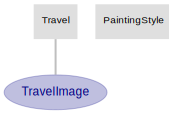

In [10]:
dj.Di(schema)

In [11]:
PaintingStyle()

*style_name   
+------------+
la_muse       
mosaic        
starry_night  
udnie         
 (Total: 4)

In [15]:
@schema
class TravelStyle(dj.Computed):
    definition = """
    -> TravelImage
    -> PaintingStyle
     ---
    image : longblob
    """
    
    def make(self, key):
        style_path = 'models/' + key['style_name'] + '.t7'
        image = (TravelImage & key).fetch1('location_image')
        style = (PaintingStyle & key).fetch1('style_name')
        
        net = cv2.dnn.readNetFromTorch(style_path)    
        image = imutils.resize(image, width=600)
        (h, w) = image.shape[:2]

        # construct a blob from the image, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
            (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()

        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output = output.transpose(1, 2, 0)
        output = np.clip(output, 0, 255)
        output= output.astype('uint8')
        
        print('location: {location}, style_name: {style_name}'.format(**key))
        self.insert1(dict(key, image=output))
        

In [16]:
TravelStyle.populate()

location: Disney World, style_name: la_muse
location: Disney World, style_name: mosaic
location: Disney World, style_name: starry_night
location: Disney World, style_name: udnie
location: Iguazu Falls, style_name: la_muse
location: Iguazu Falls, style_name: mosaic
location: Iguazu Falls, style_name: starry_night
location: Iguazu Falls, style_name: udnie
location: Moscow, style_name: la_muse
location: Moscow, style_name: mosaic
location: Moscow, style_name: starry_night
location: Moscow, style_name: udnie
location: Telc, style_name: la_muse
location: Telc, style_name: mosaic
location: Telc, style_name: starry_night
location: Telc, style_name: udnie
location: Tulum, style_name: la_muse
location: Tulum, style_name: mosaic
location: Tulum, style_name: starry_night
location: Tulum, style_name: udnie


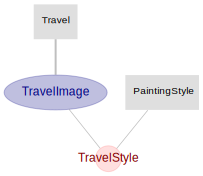

In [17]:
dj.Di(schema)

In [23]:
TravelStyle()

*location      *style_name    image     
+------------+ +------------+ +--------+
Disney World   la_muse        =BLOB=    
Disney World   mosaic         =BLOB=    
Disney World   starry_night   =BLOB=    
Disney World   udnie          =BLOB=    
Iguazu Falls   la_muse        =BLOB=    
Iguazu Falls   mosaic         =BLOB=    
Iguazu Falls   starry_night   =BLOB=    
Iguazu Falls   udnie          =BLOB=    
Moscow         la_muse        =BLOB=    
Moscow         mosaic         =BLOB=    
Moscow         starry_night   =BLOB=    
Moscow         udnie          =BLOB=    
   ...
 (Total: 20)

Pictures with styles applied 

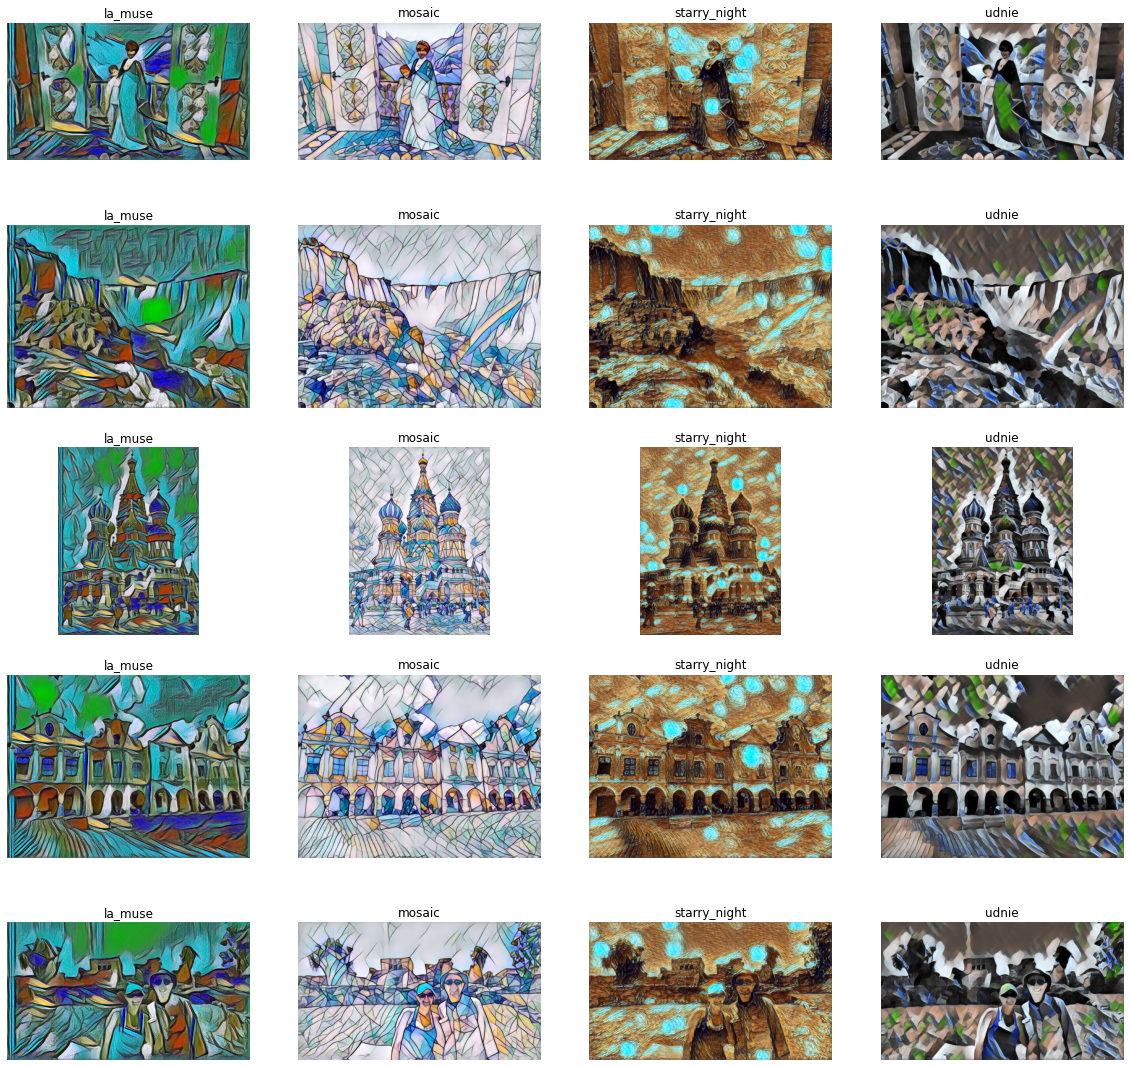

In [62]:
fig, axx = plt.subplots(5, 4, figsize=(20, 20))

for ax, info in zip(axx.flatten(), 
                    (Travel*TravelStyle).fetch(as_dict=True)):
    ax.imshow(info['image'])
    ax.set_title(info['style_name'])
    ax.axis(False)
plt.savefig('travelpics.png')

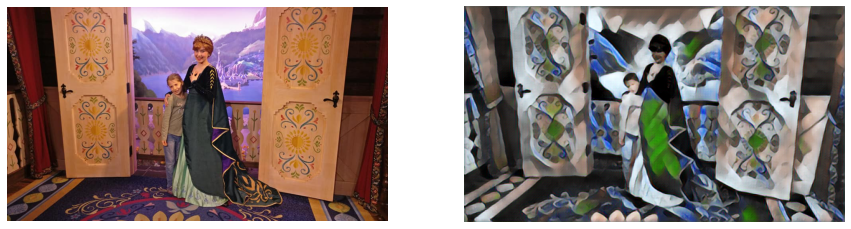

In [29]:
key = dict(location='Disney World')
key['style_name'] = 'udnie'
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow((TravelImage & key).fetch1('location_image'))
ax[0].axis(False)
ax[1].imshow((TravelStyle & key).fetch1('image'))
ax[1].axis(False);

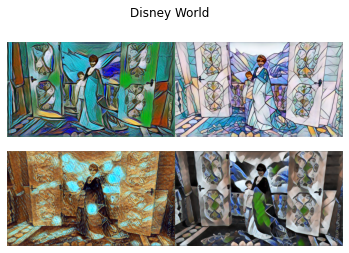

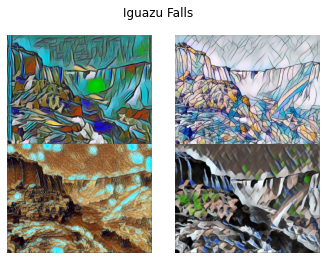

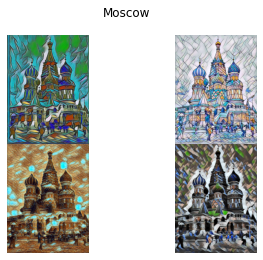

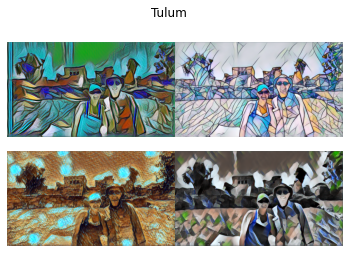

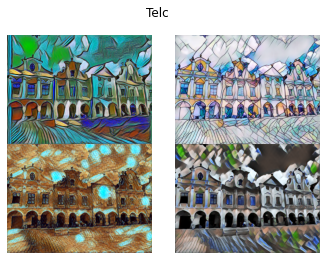

In [57]:
locations = ('Disney World', 'Iguazu Falls', 'Moscow','Tulum', 'Telc')
for location in locations:
    key = dict(location = location)
    fig, axx = plt.subplots(2,2)

    for ax, info in zip(axx.flatten(), 
                    (Travel*TravelStyle & key).fetch(as_dict=True)):
        ax.imshow(info['image'])
        ax.axis(False)
    fig.suptitle(location)
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.savefig(f'{location}.png')

Clean Up

In [ ]:
schema.drop()

In [ ]:
import shutil
shutil.rmtree('cached')